# Optimization of compute bound Python code 

## Layout:

* Forword about optimization and profiling:
    - No optimisation without profiling
    - No benchmarking without tests
* Presentation of the example:
    - Square crystal: demonstration
    - Relaxated circular crystal: exercise
* `Python` version:
    - code with loops ala `FORTRAN`
    - Bottleneck search
* `Numpy` vectorized version:
    - Limits of vectorization: cache sizes
[...]

* `Numexpr` compiler for mathematical formula
    - Single and multi-threaded evaluation
    - Limits of `numexpr`
* `Numba`: just in time compilation of numerical code
    - Decoration of function
    - Type annotation
    - Limits of `numba`
* `Cython`: ahead of time compilation
    - `Cython` usage within `Jupyter`
    - Annotated compilation 
    - Single threaded performances
    - Parallelization with OpenMP
    - Mixing Extensions with Python threads
* Conclusions:
    - Only addresses CPU-bound issues, not I/O issues
    - If you problem is still CPU-bound, is possible when moving to GPU

## Definitions:
* In computer science, software **optimization** is the process of modifying a software system to make some aspect of it work more efficiently or use fewer resources.[Wikipedia]
* In software engineering, software **profiling** is a form of dynamic program analysis that measures, for example, the space (memory) or time complexity of a program, the usage of particular instructions, or the frequency and duration of function calls. Most commonly, profiling information serves to aid program optimization, and more specifically, performance engineering. [Wikipedia]
* Regression **testing** is re-running functional and non-functional tests to ensure that previously developed and tested software still performs after a change. If not, that would be called a regression.

## Profiling in Python

The standard library of *Python* contains the **cProfile** module which collects information about the running code. It is a *C* version of the *profile* module.

Profiling induces slow-down, it should be distinguished from form *benchmarking*.

Profile results can be analyzed with the *pstats* module or exernal programs like **RunSnakeRun**, **SnakeViz** or **kcachegrind**. 

In [1]:
import math, cProfile
prf = cProfile.Profile()
prf.enable() # Start of the profiled section:
size = 1000000
distance = 1; tth = []
for i in range(size):
    x_i = size//1000/1000
    y_i = size%1000/1000
    radius = math.sqrt(x_i**2 + y_i**2)
    tth.append(math.atan2(radius, distance))
prf.disable() #End of section:
prf.dump_stats("profile.log"); prf.print_stats() # Save / display some results

         3000110 function calls in 0.908 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <ipython-input-1-fa60611d6caf>:11(<module>)
        1    0.000    0.000    0.000    0.000 <ipython-input-1-fa60611d6caf>:4(<module>)
        1    0.000    0.000    0.000    0.000 <ipython-input-1-fa60611d6caf>:5(<module>)
        1    0.680    0.680    0.908    0.908 <ipython-input-1-fa60611d6caf>:6(<module>)
        5    0.000    0.000    0.000    0.000 codeop.py:142(__call__)
       10    0.000    0.000    0.000    0.000 compilerop.py:138(extra_flags)
        5    0.000    0.000    0.000    0.000 contextlib.py:112(__enter__)
        5    0.000    0.000    0.000    0.000 contextlib.py:121(__exit__)
        5    0.000    0.000    0.000    0.000 contextlib.py:242(helper)
        5    0.000    0.000    0.000    0.000 contextlib.py:86(__init__)
        5    0.000    0.000    0.000    0.000 hook

Example of visualization of the profiling with **runSnakeRun**. Equivalent visualization is available from the other tools.

This is the typical way of using the Python profiler. Another way to use it is to invoque it when starting the process:

`python -m cProfile -o profile.log myscript.py`

There is also the `%prun` magic jupyter command to run the line/cell with the profiler enabled.

## Two-dimensional Laue function example

All this training is based on the same example: 2D diffraction from a finite size crystallite given by Laue function:

$$ I(H,K) = \left | \sum_{n=0}^{N-1} \sum_{m=0}^{N-1} \exp \left [ 2 \pi i \left ( H n + K m \right ) \right ] \right| ^2 $$

This equation describes the scattering from square crystal having *N* unit-cells in both directions; *n* and
*m* are the indices of the unit-cell in each direction and *H* and *K* are the continuous Miller indices which are sampled in the neighborhood of *H,K* [H-0.5:H+0.5, K-0.5:K+0.5] to build an image of the diffraction peak.

This example is derived from: https://journals.iucr.org/j/issues/2019/04/00/gj5229/gj5229.pdf

In [2]:
%matplotlib inline 
# This is for plotting
import os
import math
import cmath
import cpuinfo
import numpy as np
import numba as nb
import numexpr as ne
from matplotlib.pyplot import subplots
from matplotlib.colors import LogNorm

In [3]:
# Description of the system:
n_cpu = os.cpu_count()
print(f"We are working on a computer with {n_cpu} cores")
#Reduce this number if you have booked only a smaller number of cores
# n_cpu = 8
# print(f"We are using only {n_cpu} cores") 
for kk, v in cpuinfo.get_cpu_info().items():
    if "cache_size" in kk:
        print(kk, v)

We are working on a computer with 16 cores
l3_cache_size 524288
l2_cache_size 65536


In [4]:
#Some constants valid for all calculation
#Miller index of reflection
H = 0 
#Miller index of reflection
K = 4 
#Number of units cells per direction
N = 32 
#Defines how much points are needed to describe a single Laue fringe (2 = Nyquist frequency)
oversampling = 3
#Maximum strain at surface
e0 = 0.01 
#Width of the strain profile below the surface
w = 5. 

#Generate real and reciprocal space coordinates
n = np.arange(N)
m = np.arange(N)
h = np.arange(H-0.5, H+0.5, 1./(oversampling*N))
k = np.arange(K-0.5, K+0.5, 1./(oversampling*N))

In [5]:
def Laue_python(n, m, h, k):
    result = [[0 for x in range(len(h))] for y in range(len(k))]
    for i_h, v_h in enumerate(h):  # loop over the reciprocal space coordinates
        for i_k, v_k in enumerate(k):
            tmp = 0.0
            for i_n in n:  # loop and sum over unit-cells
                for i_m in m:
                    tmp += cmath.exp(2j*np.pi*(v_h*i_n + v_k*i_m))
            result[i_h][i_k] = abs(tmp)**2
    return np.array(result)

#Compute
%time square_intensity = Laue_python(n, m, h, k)

CPU times: user 6.19 s, sys: 0 ns, total: 6.19 s
Wall time: 6.19 s


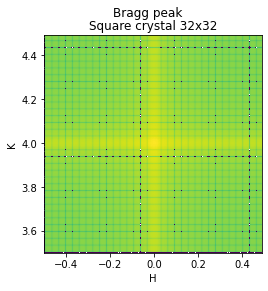

In [6]:
# Visualization of the reference image
fig, ax = subplots()
ax.imshow(square_intensity.T, extent=(h.min(), h.max(), k.min(), k.max()), norm=LogNorm(), origin = 'lower')
ax.set_xlabel('H')
ax.set_ylabel('K')
fig.suptitle("Bragg peak")
title = ax.set_title(f"Square crystal {N}x{N}")

### Validation of optimization

Code optimization should always be performed with some tests to ensure the speed-up obtained is not degrading the numerical quality !

In [7]:
# Validation of the result:
def validate_sq(result):
    "Return the error value"
    reference = np.load("reference_sq.npy")
    return abs(reference-result).max()/reference.max()

# Validation of the result (for the exercises):
def validate_ci(result):
    "Return the error value"
    reference = np.load("reference_ci.npy")
    return abs(np.array(reference)-result).max()/reference.max()

print("Error measured:", validate_sq(square_intensity))

Error measured: 4.218847493575595e-15


In [8]:
perf_sq_python = %timeit -o Laue_python(n, m, h, k)

6.06 s ± 73.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Exercise:

Let us now consider a case where the crystal has not a square shape and which additionally
exhibits strain. 


The first point implies that the unit-cell coordinates can not be simply represented by a
array, and it is necessary to introduce a support function, `Omega`, equal to one when the unit-cell coordinate is
located inside the crystal, and 0 otherwise.

1. Write a function generating the diffraction from a circular 2D crystal (inscribed in the square considered previously). One may consider the radius of the disk to be $R=N/2$.

The previous formula becomes then:
$$ I(H,K) = \left | \sum_{n=0}^{N-1} \sum_{m=0}^{N-1} \Omega \left (n,m \right ) \exp \left \{ 2 \pi i \left [ H n + K m) \right ] \right \} \right | ^2$$

How do those modifications affect the execution speed ?

The second point implies that unit-cells are shifted from their regular position according to $n’ = n + Δn$, where $Δn$ is the displacement.
For the case of a circular crystal, a function describing a progressive dilatation when moving from the
center towards the periphery can be written:

$$  \overrightarrow{\Delta r}(\overrightarrow{r}) = e_{0} \overrightarrow{r} (1 + tanh(\frac{r-R}{w})) $$

where Δr(r) is the displacement of the unit-cell located at a distance r from the crystal center, $e_0$ is the
maximum strain, and w is a parameter describing the width of the displacement profile (for small
values of w the strain is confined at the periphery of the crystal, whereas large values also affect the
interior of the crystal).

2. Modify the function to take into account the displacement induced by the strain.

The previous formula becomes then:
$$ I(H,K) = \left | \sum_{n=0}^{N-1} \sum_{m=0}^{N-1} \Omega \left (n,m \right ) \exp \left \{ 2 \pi i \left [ H \left (n + \Delta n\right )+ K \left (m + \Delta m\right ) \right ] \right \} \right | ^2$$




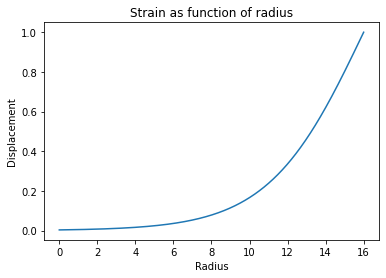

In [9]:
# Displacement of atoms as function of the radius
fig, ax = subplots()
x=np.linspace(0, N/2 , 1000)
ax.plot(x, 1+np.tanh((x-N/2)/w))
ax.set_xlabel("Radius")
ax.set_ylabel("Displacement")
t=ax.set_title("Strain as function of radius")

In [10]:
def Circ_python_1(n, m, h, k):
    x = np.atleast_2d(n-N/2)
    y = np.atleast_2d(m/N/2).T
    omega = x*x + y*y <=N*N/4
    result = [[0 for x in range(len(h))] for y in range(len(k))]
    for i_h, v_h in enumerate(h): #loop over the reciprocal space coordinates
        for i_k, v_k in enumerate(k):
            #One should discard  bad values
            tmp = 0.0
            for i_n in n:#loop and sum over unit-cells
                for i_m in m:
                    if omega[i_n, i_m]:
                        tmp += cmath.exp(2j*np.pi*(v_h*i_n + v_k*i_m))
            result[i_h][i_k] = abs(tmp)**2
    return np.array(result)

#Compute
%time intensity_circle = Circ_python_1(n, m, h, k)
print("Error:", validate_ci(intensity_circle))

CPU times: user 8.04 s, sys: 0 ns, total: 8.04 s
Wall time: 8.04 s
Error: 1.6782257638277525


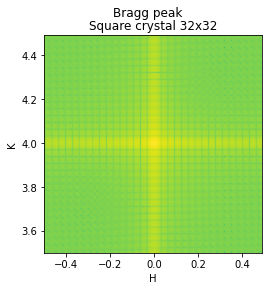

In [11]:
# Visualization of the reference image
fig, ax = subplots()
ax.imshow(intensity_circle.T, extent=(h.min(), h.max(), k.min(), k.max()), norm=LogNorm(), origin = 'lower')
ax.set_xlabel('H')
ax.set_ylabel('K')
fig.suptitle("Bragg peak")
title = ax.set_title(f"Square crystal {N}x{N}")

CPU times: user 5.7 s, sys: 0 ns, total: 5.7 s
Wall time: 5.7 s


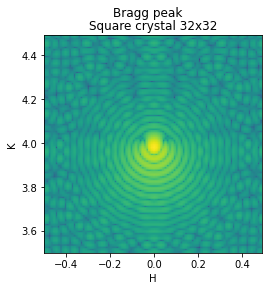

In [12]:
def Circ_python_2(n, m, h, k):
    N_2 = N / 2
    positions = {}
    for i in n:
        x = i - N_2
        for j in m:
            y = j - N_2
            r = (x*x + y*y)**0.5
            if r<=N_2:
                strain = 𝑒0 * (1 + math.tanh((r - N_2)/w))
                positions[(i,j)] = (i + strain*x,
                                    j + strain*y)
    result = [[0 for x in range(len(h))] for y in range(len(k))]
    for i_h, v_h in enumerate(h): #loop over the reciprocal space coordinates
        for i_k, v_k in enumerate(k):
            #One should discard  bad values
            tmp = 0.0
            for i_n in n:#loop and sum over unit-cells
                for i_m in m:
                    pos = positions.get((i_n, i_m))
                    if pos:
                        n_s, m_s = pos
                        tmp += cmath.exp(2j*np.pi*(v_h*n_s + v_k*m_s))
            result[i_h][i_k] = abs(tmp)**2
    return np.array(result)
%time intensity_circle = Circ_python_2(n, m, h, k)
# Visualization of the reference image
fig, ax = subplots()
ax.imshow(intensity_circle.T, extent=(h.min(), h.max(), k.min(), k.max()), norm=LogNorm(), origin = 'lower')
ax.set_xlabel('H')
ax.set_ylabel('K')
fig.suptitle("Bragg peak")
title = ax.set_title(f"Square crystal {N}x{N}")

CPU times: user 423 ms, sys: 8.05 ms, total: 431 ms
Wall time: 430 ms


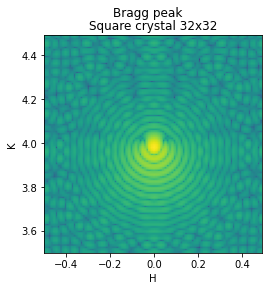

In [13]:

def Circ_numexpr(n, m, h, k, e0, w):
    N = len(n)
    h = h[:, np.newaxis, np.newaxis, np.newaxis]
    k = k[np.newaxis, :, np.newaxis, np.newaxis]
    n = n[np.newaxis, np.newaxis, :, np.newaxis]
    m = m[np.newaxis, np.newaxis, np.newaxis, :]
    ne.set_num_threads(1)
    radius = ne.evaluate("sqrt((n - N/2)**2 + (m - N/2)**2)")
    strain = ne.evaluate("e0 * (1 + tanh((radius-N/2) / w))")
    j2pi = np.pi*2j
    tmp = ne.evaluate("where(radius > N/2, 0, exp(j2pi*(h*(n+strain*(n-N/2)) + k*(m+strain*(m-N/2)))))")
    result = abs(tmp.sum(axis=(2,3)))**2
    return result
%time intensity_circle = Circ_numexpr(n, m, h, k, e0, w)
# Visualization of the reference image
fig, ax = subplots()
ax.imshow(intensity_circle.T, extent=(h.min(), h.max(), k.min(), k.max()), norm=LogNorm(), origin = 'lower')
ax.set_xlabel('H')
ax.set_ylabel('K')
fig.suptitle("Bragg peak")
title = ax.set_title(f"Square crystal {N}x{N}")

# Jupyter magick functions for profiling:

* `%time`: Measures the time to run the function, once
* `%timeit`: Measures the time in benchmarking mode (many repetitions, garbage collector disabled, ...)
* `%prun`: run withing the profiler
* `%lprun`: run with the line-profiler active

All those functions can be used with `%%` to apply to the full cell instead of a single command.
    
Mind to ask for their help ... sometimes they have multiple options `%timeit?`


In [14]:
# Run a function in the Python profiler ...
%prun -D square.log Laue_python(n, m, h, k)

 
*** Profile stats marshalled to file 'square.log'. 


In [15]:
%load_ext line_profiler

In [16]:
%lprun -f Laue_python Laue_python(n, m, h, k)

**Exercise:** Profile your strained crystal diffraction with `prun` and `lprun`.

## Optimization with `NumPy`

Python is a dynamic language and is known to be pretty inefficient when looping over large datasets.
The `numpy` library offers vectorial notation which avoid those loops.

This is how the previous function writes in a fully vectorial way:

In [17]:
def Laue_numpy(n, m, h, k):
    h = h[:, np.newaxis, np.newaxis, np.newaxis]
    k = k[np.newaxis, :, np.newaxis, np.newaxis]
    n = n[np.newaxis, np.newaxis, :, np.newaxis]
    m = m[np.newaxis, np.newaxis, np.newaxis, :]
    return np.abs(np.exp(2j*np.pi*(h*n + k*m)).sum(axis=(2,3)))**2

#Compute and check error
%time intensity = Laue_numpy(n, m, h, k)
print("Error:", validate_sq(intensity))

CPU times: user 286 ms, sys: 36 ms, total: 322 ms
Wall time: 321 ms
Error: 0.0


The first striking observation is that the code is much more concise. 

It is also much clearer since the actual calculation requires one line (line 6) with a syntax similar to the provided Equation. 

Lines 2-5 add new (empty) dimensions to the input arrays. With this transformation the calculation of h*n + k*m actually returns a 4-dimensional array. This important feature of NumPy is known as “broadcasting”. 
The exponential then operates on all cells of this array,
and the sum over the real-space coordinates is performed using the sum() method of the NumPy arrays,
line 6 (the “ axis=(2,3) ” argument designates the fact that the summation has to be performed over the
last two dimensions of the array that contain the real space variables). 

Besides the cleaner syntax, this implementation is also much faster than Python code.

In [18]:
perf_sq_numpy = %timeit -o Laue_numpy(n, m, h, k)

319 ms ± 2.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Exercise:** Implement the strained crystal diffraction using `NumPy`.

### Limits of `numpy`'s vectorization

When calculating expression like "a+2*b+5*c+a*b", each individual operation creates a new temporary array where all results of each binary operation are stored. This can be an issue when the number of operand is large and that those temporary array are larger than the cache size of the processor. Those temporary array needs to go back to central memory before starting next operation and this is bad for performances.

In [19]:
#Importance of the cache:
def tmp_numpy(n, m, h, k):
    h = h[:, np.newaxis, np.newaxis, np.newaxis]
    k = k[np.newaxis, :, np.newaxis, np.newaxis]
    n = n[np.newaxis, np.newaxis, :, np.newaxis]
    m = m[np.newaxis, np.newaxis, np.newaxis, :]
    return np.exp(2j*np.pi*(h*n + k*m))
print("Size of the intermediate array: ", tmp_numpy(n,m,h,k).nbytes)

Size of the intermediate array:  150994944


## `NumExpr` is a fast numerical expression evaluator for `NumPy`.

It works best for evaluating large numerical expressions on arrays which do not fit into cache. The speed-up is typically of the order of 4-8 (may be limited by the number of cores since `numexpr` uses all cores).

In [29]:
ne.set_num_threads(8)  # Limit the number of threads to be used

def Laue_numexpr(n, m, h, k):
    h = h[:, np.newaxis, np.newaxis, np.newaxis]
    k = k[np.newaxis, :, np.newaxis, np.newaxis]
    n = n[np.newaxis, np.newaxis, :, np.newaxis]
    m = m[np.newaxis, np.newaxis, np.newaxis, :]
    j2pi = np.pi*2j
    tmp = ne.evaluate("exp(j2pi*(h*n + k*m))")
    return np.abs(tmp.sum(axis=(2,3)))**2

#Compute and check error
%time intensity = Laue_numexpr(n, m, h, k)
print("Error:", validate_sq(intensity))

CPU times: user 475 ms, sys: 28.4 ms, total: 504 ms
Wall time: 78.3 ms
Error: 0.0


**Exercise:** Implement the strained crystal diffraction using `NumExpr`.

In [30]:
perf_sq_numexpr = %timeit -o Laue_numexpr(n, m, h, k)

57.4 ms ± 937 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Numba
`Numba` is an open source, **Just In Time** compiler that translates a subset of `Python` and `NumPy` code into fast machine code. 
It usually performs better on explicit loops but accepts most of the `NumPy` constructions.

In [22]:
@nb.jit(nb.float64[:,:](nb.int64[:],nb.int64[:],nb.float64[:],nb.float64[:]), 
        nopython=True, parallel=True)
def Laue_numba(n,m,h,k):
    result = np.zeros(h.size*k.size, dtype=nb.float64)
    for i in nb.prange(h.size*k.size): #loop over the reciprocal space coordinates
        tmp = 0j
        for i_n in n:
            for i_m in m:#loop and sum over unit-cells
                tmp +=  cmath.exp(2j*cmath.pi*(h[i//k.size]*i_n + k[i%k.size]*i_m))
        result[i] = abs(tmp)**2
    return result.reshape(len(h),len(k))

#Compute and check error
%time intensity = Laue_numba(n, m, h, k)
print("Error:", validate_sq(intensity))

CPU times: user 601 ms, sys: 4.03 ms, total: 605 ms
Wall time: 51.4 ms
Error: 4.218847493575595e-15


In [23]:
perf_sq_numba = %timeit -o Laue_numba(n, m, h, k)

23.8 ms ± 163 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Drawback of `Numba`
`Numba` being a JIT compiler, it requires the compiler `LLVM-lite` to be installed and configured on every single node.

The second drawback is the JIT: the compilation will be performed for the first execution of a session and if it runs on a cluster, the compilation will occure on every node. Numba is hence not mutli-processing friendly.

Finally the support for multi-threading and classes looks brittle, at least when evaluated.

## Conclusions

Within the Python ecosystem, the `NumPy` library is the *de facto* standard when it comes to scientific
computing. As long as the algorithms are properly vectorized and the memory is large enough to store
the arrays, it allows to reach high computational performances while keeping a clean and simple code,
close to mathematical notation. Used in combination with the `NumExpr` library, simple NumPy code
can benefit from multi-core CPUs as well as optimized memory management, with very little code
modification.

In the case where it is not possible to vectorize the algorithms, or when increased performances are
critical, one must make use of compilers that translate Python code into statically-typed code that also
provide an improved support of multi-core architectures. We have shown that `Numba` and `Cython` in
general exhibit very close performances and, given the heavier syntax of `Cython`, `Numba` is easier to
implement. Cython, on the other hand, allows to access more advanced options regarding thread and
memory management.

### Summary of the execution runtime:

In [31]:
print("Runtime  square      circle")
print(f"Python  {perf_sq_python.best:6.3f} s  {np.NaN:6.3f} s")
print(f"Numpy   {perf_sq_numpy.best:6.3f} s  {np.NaN:6.3f} s")
print(f"NumExpr {perf_sq_numexpr.best:6.3f} s  {np.NaN:6.3f} s")
print(f"Numba   {perf_sq_numba.best:6.3f} s  {np.NaN:6.3f} s")
print(f"Cython  {np.NaN:6.3f} s  {np.NaN:6.3f} s")

Runtime  square      circle
Python   5.957 s     nan s
Numpy    0.318 s     nan s
NumExpr  0.057 s     nan s
Numba    0.024 s     nan s
Cython     nan s     nan s
